In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data_dir = "D:/Internships/Pantech/code/BMS/cleaned_dataset/data"

csv_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(".csv")]
print(f"Number of CSV files found: {len(csv_files)}")

Number of CSV files found: 7565


In [3]:
# Combine all CSV files into a single DataFrame

data_list = []
for file in csv_files:
    data = pd.read_csv(file)
    data_list.append(data)

# Merge
combined_data = pd.concat(data_list, ignore_index=True)

print("\nCombined Data Info:")
print(combined_data.info())


Combined Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7376834 entries, 0 to 7376833
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Voltage_measured      float64
 1   Current_measured      float64
 2   Temperature_measured  float64
 3   Current_load          float64
 4   Voltage_load          float64
 5   Time                  float64
 6   Sense_current         object 
 7   Battery_current       object 
 8   Current_ratio         object 
 9   Battery_impedance     object 
 10  Rectified_Impedance   object 
 11  Current_charge        float64
 12  Voltage_charge        float64
dtypes: float64(8), object(5)
memory usage: 731.7+ MB
None


In [4]:
# Handle missing values
numeric_columns = combined_data.select_dtypes(include=[np.number]).columns  # Select only numeric columns
combined_data[numeric_columns] = combined_data[numeric_columns].fillna(combined_data[numeric_columns].mean())

In [5]:
df = combined_data.copy()

#### Feature Engineering

In [6]:
df['ambient_temperature'] = 0
df['time'] = 0

df['id_cycle'] = df.groupby('Time').ngroup()

df['Capacity'] = df['Current_charge'] * df['Time']

max_capacity = df['Capacity'].max()

df['Capacity_Fade'] = df['Capacity'].iloc[0] - df['Capacity']

df['Resistance_Increase'] = df['Capacity_Fade'] / (max_capacity)

df['Temperature_variation'] = df.groupby('id_cycle')['Temperature_measured'].transform('std')

df['Average_discharge_current'] = df.groupby('id_cycle')['Current_measured'].transform('mean')

df['Discharge_Time'] = df.groupby('id_cycle')['Time'].transform('max')

V_min = df['Voltage_measured'].min()
V_max = df['Voltage_measured'].max()

df['Estimated_SoC'] = ((df['Voltage_measured'] - V_min) / (V_max - V_min)) * 100
df['Estimated_SoH'] = (df['Capacity'] / df['Capacity'].max()) * 100


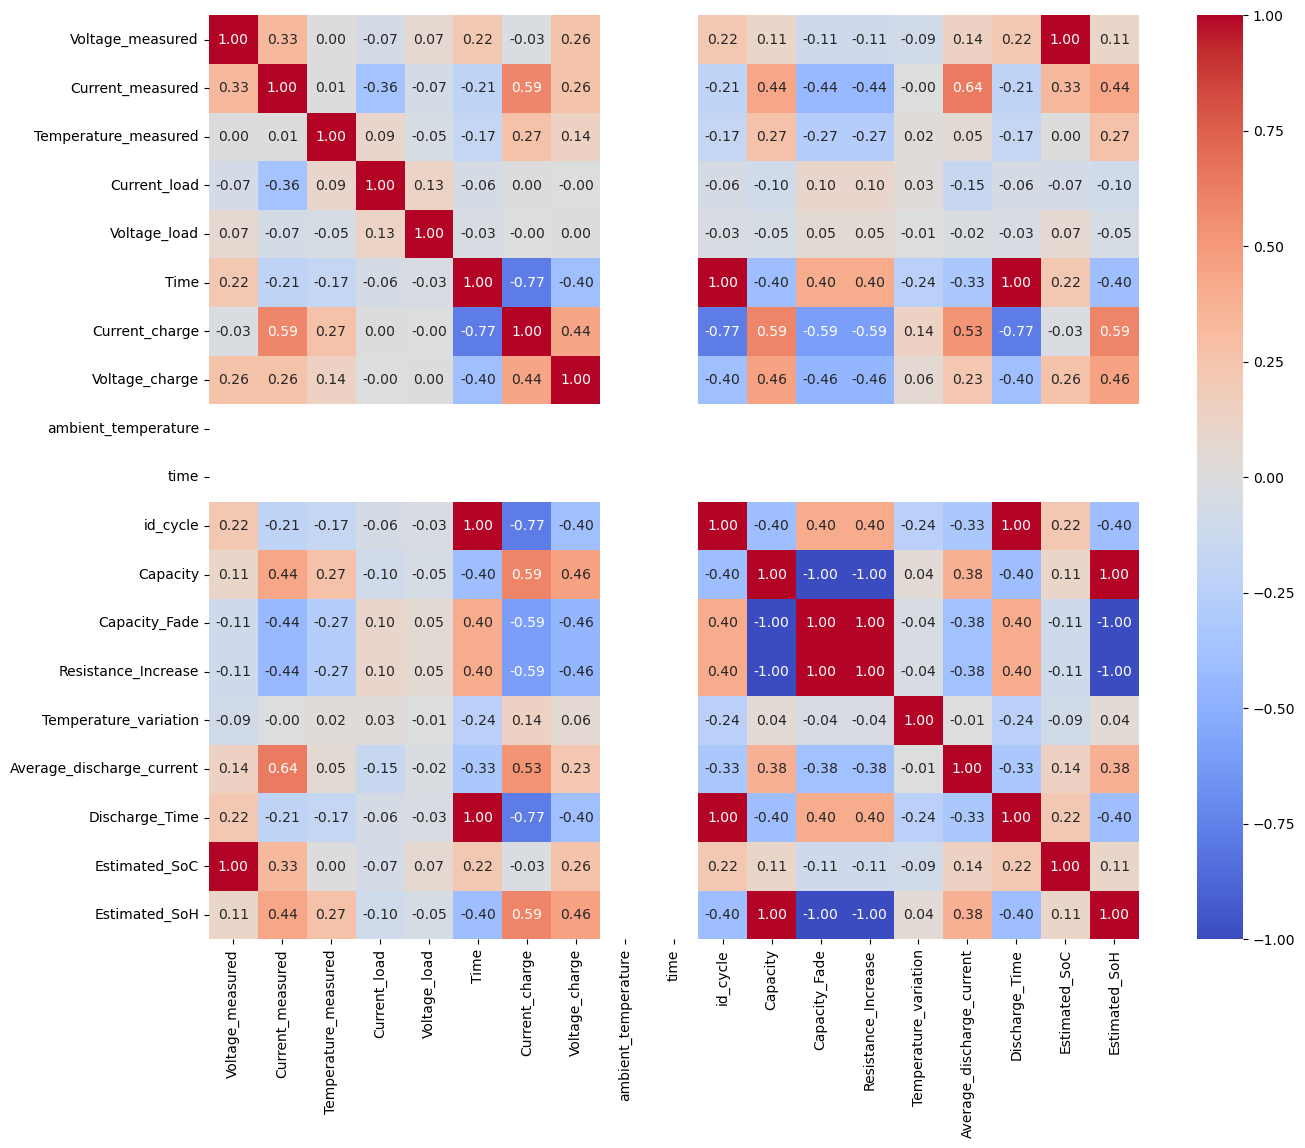

In [7]:
corr = df.corr(numeric_only=True)
plt.figure(figsize =(15, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

#### Feature Selection

In [9]:
target_variable = 'Estimated_SoH'
threshold = 0.45

correlation_with_target = corr[target_variable]

relevant_features = correlation_with_target[(correlation_with_target >= threshold) | (correlation_with_target <= -threshold)]

relevant_features = relevant_features.drop(target_variable, errors='ignore')

print("Relevant features with respect to Estimated_SoH:")
print(relevant_features)

Relevant features with respect to Estimated_SoH:
Current_charge         0.594741
Voltage_charge         0.456888
Capacity               1.000000
Capacity_Fade         -1.000000
Resistance_Increase   -1.000000
Name: Estimated_SoH, dtype: float64


Relevant features (wrt SoC and SoH) from the heatmap are:
- for Soc:
1. Voltage_measured
2. Current_measured
3. Voltage_charge
- for SoH:
1. Capacity
2. Capacity_Fade
3. Resistance_Increase
4. Current_charge
5. Voltage_charge

In [8]:
selected_features_soc = ['Voltage_measured',
'Current_measured',
'Voltage_charge']
selected_features_soh = ['Capacity',
'Capacity_Fade',
'Resistance_Increase',
'Current_charge',
'Voltage_charge']

# MODELS

### Deep Neural Network (DNN)

In [9]:
#!pip3 install tensorflow==2.18.0
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [10]:
X_soc = df[selected_features_soc]
y_soc = df['Estimated_SoC']

X_soh = df[selected_features_soh]
y_soh = df['Estimated_SoH']

# Split into 70% training and 30% (validation + testing)
X_soc_train, X_soc_temp, y_soc_train, y_soc_temp = train_test_split(X_soc, y_soc, test_size=0.3, random_state=42)

# Split the 30% (validation + testing) into 20% validation and 10% testing
X_soc_val, X_soc_test, y_soc_val, y_soc_test = train_test_split(X_soc_temp, y_soc_temp, test_size=(1/3), random_state=42)


X_soh_train, X_soh_temp, y_soh_train, y_soh_temp = train_test_split(X_soh, y_soh, test_size=0.3, random_state=42)
X_soh_val, X_soh_test, y_soh_val, y_soh_test = train_test_split(X_soh_temp, y_soh_temp, test_size=(1/3), random_state=42)

##### DNN for SoC

In [12]:
model_soc_dnn = Sequential([
    Dense(64, activation='relu', input_dim=X_soc_train.shape[1]),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])
model_soc_dnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history_soc_dnn = model_soc_dnn.fit(X_soc_train, y_soc_train, epochs=5, batch_size=32, validation_data=(X_soc_val, y_soc_val))


D:\Apps\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 501s 3ms/step - loss: 7.0118 - mae: 0.2206 - val_loss: 1.5992e-04 - val_mae: 0.0123
Epoch 2/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 499s 3ms/step - loss: 7.0560e-04 - mae: 0.0153 - val_loss: 1.3305e-04 - val_mae: 0.0094
Epoch 3/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 479s 3ms/step - loss: 5.4274e-04 - mae: 0.0130 - val_loss: 2.2117e-05 - val_mae: 0.0038
Epoch 4/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 451s 3ms/step - loss: 4.5794e-04 - mae: 0.0120 - val_loss: 8.0263e-05 - val_mae: 0.0088
Epoch 5/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 421s 3ms/step - loss: 4.2087e-04 - mae: 0.0111 - val_loss: 1.9981e-06 - val_mae: 0.0012


In [13]:
#Evaluate
y_soc_pred_dnn = model_soc_dnn.predict(X_soc_test)
mse_soc = mean_squared_error(y_soc_test, y_soc_pred_dnn)
mae_soc = mean_absolute_error(y_soc_test, y_soc_pred_dnn)
r2_soc = r2_score(y_soc_test, y_soc_pred_dnn)

print("DNN Model for SoC:\nMSE:", mse_soc, "\nMAE:", mae_soc, "\nR^2:", r2_soc)

23053/23053 ━━━━━━━━━━━━━━━━━━━━ 22s 968us/step
DNN Model for SoC:
MSE: 1.982248864272678e-06 
MAE: 0.001169347090590118 
R^2: 0.9999999360357436


- MSE value is very small (2*10^-6)=> differences between the predicted and true SoC values are very small. This indicates that the model is performing exceptionally well in capturing the true behavior of the data.
- MAE: on average, the model's predictions deviate from the true SoC values by only 0.0011 units. This further supports the model's high accuracy.
- R^2 value is close to 1 indicating that it fits very close to training data (no variance) and is near-perfect.

In [14]:
model_soc_dnn.save("model_soc_dnn.keras")
print("Model saved as 'model_soc_dnn.keras")

Model saved as 'model_soc_dnn.keras


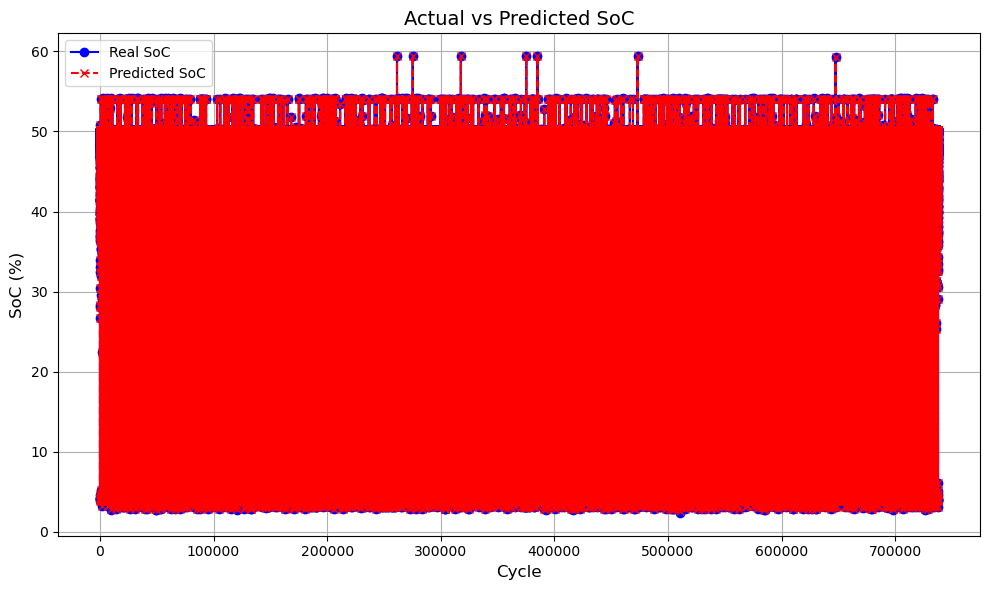

In [24]:
if len(y_soc_pred_dnn.shape) > 1:
    y_soc_pred_dnn = y_soc_pred_dnn.flatten()

plt.figure(figsize=(10, 6))
plt.plot(range(len(y_soc_test)), y_soc_test, label='Real SoC', marker='o', linestyle='-', color='blue')
plt.plot(range(len(y_soc_pred_dnn)), y_soc_pred_dnn, label='Predicted SoC', marker='x', linestyle='--', color='red')

plt.xlabel('Cycle', fontsize=12)
plt.ylabel('SoC (%)', fontsize=12)
plt.title('Actual vs Predicted SoC', fontsize=14)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

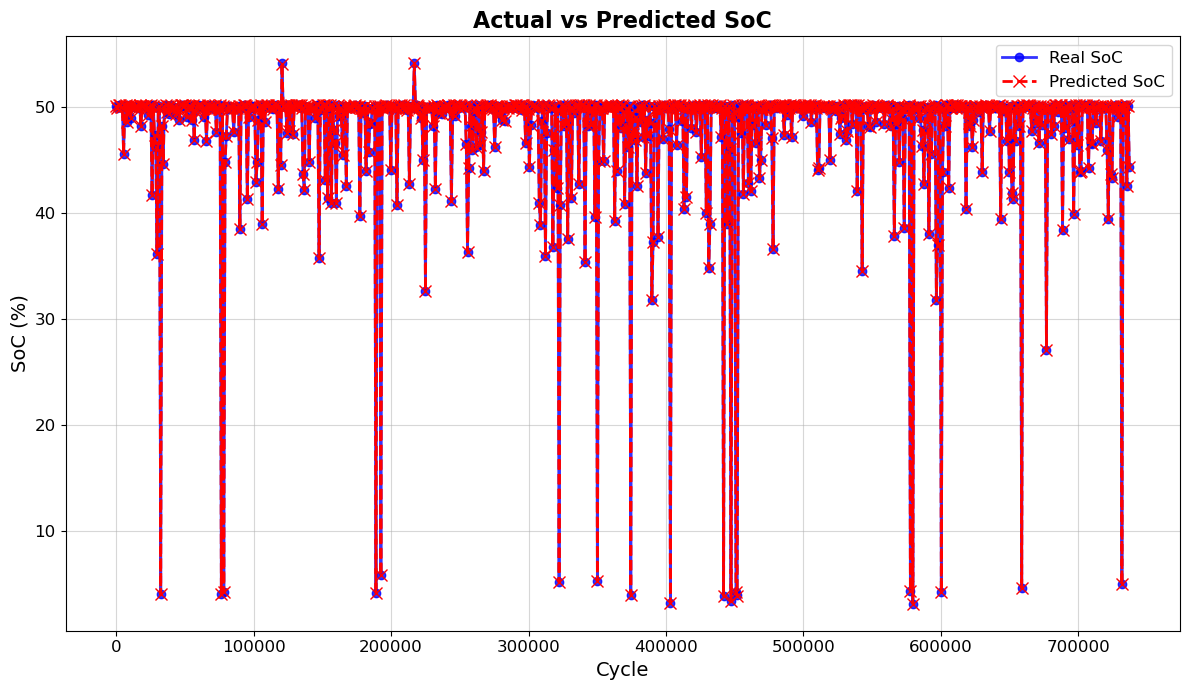

In [16]:
sampling_rate = 900
x_points = np.arange(len(y_soc_test))[::sampling_rate]
y_real_sampled = y_soc_test[::sampling_rate]
y_pred_sampled = y_soc_pred_dnn[::sampling_rate]

plt.figure(figsize=(12, 7)) 

# Plot Real SoC
plt.plot(
    x_points,
    y_real_sampled,
    label='Real SoC',
    marker='o',
    markersize=6,
    linestyle='-',
    linewidth=2,
    color='blue',
    alpha=0.8, 
)

# Plot Predicted SoC
plt.plot(
    x_points,
    y_pred_sampled,
    label='Predicted SoC',
    marker='x',
    markersize=8,
    linestyle='--',
    linewidth=2,
    color='red',
    alpha=1,
)

plt.xlabel('Cycle', fontsize=14)
plt.ylabel('SoC (%)', fontsize=14)
plt.title('Actual vs Predicted SoC', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.5)  # Add a light grid for clarity

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

##### Blue and Red dots overlap almost perfectly indicating exceptional performance of RNN over SoC values

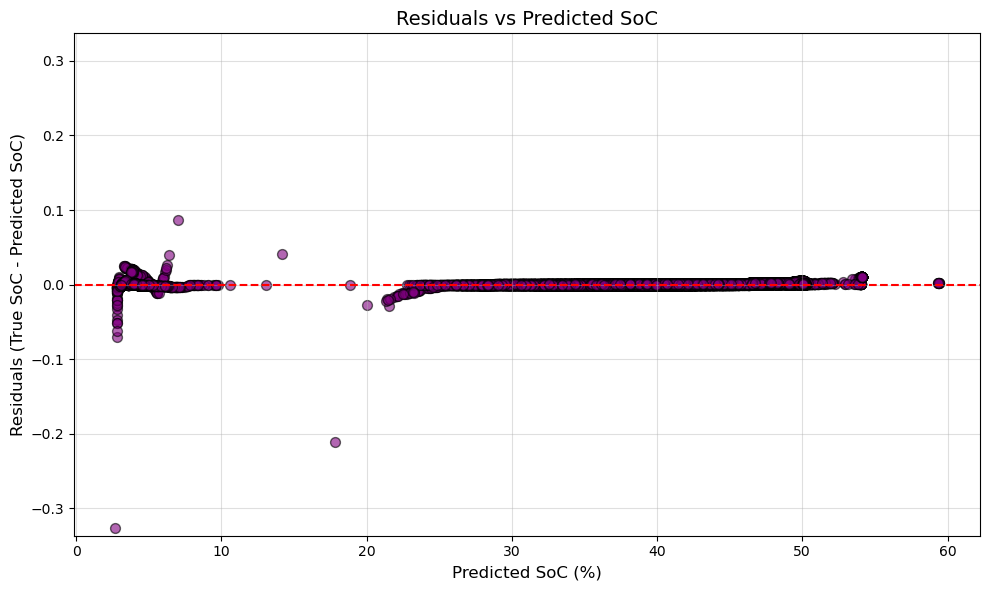

In [15]:
residuals = y_soc_test - y_soc_pred_dnn.flatten()  # Ensure y_soc_pred_dnn is a 1D array

# Determine symmetric limits for the y-axis
max_residual = max(abs(residuals))  # Get the maximum absolute residual
y_limit = max_residual + 0.01  # Add a small buffer for visualization

plt.figure(figsize=(10, 6))

plt.scatter(y_soc_pred_dnn, residuals, alpha=0.6, color='purple', edgecolor='black', s=50)

# Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

plt.ylim(-y_limit, y_limit)

plt.xlabel('Predicted SoC (%)', fontsize=12)
plt.ylabel('Residuals (True SoC - Predicted SoC)', fontsize=12)
plt.title('Residuals vs Predicted SoC', fontsize=14)

plt.grid(alpha=0.4)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

### XAI - Surrogate Summary (Linear Regression)

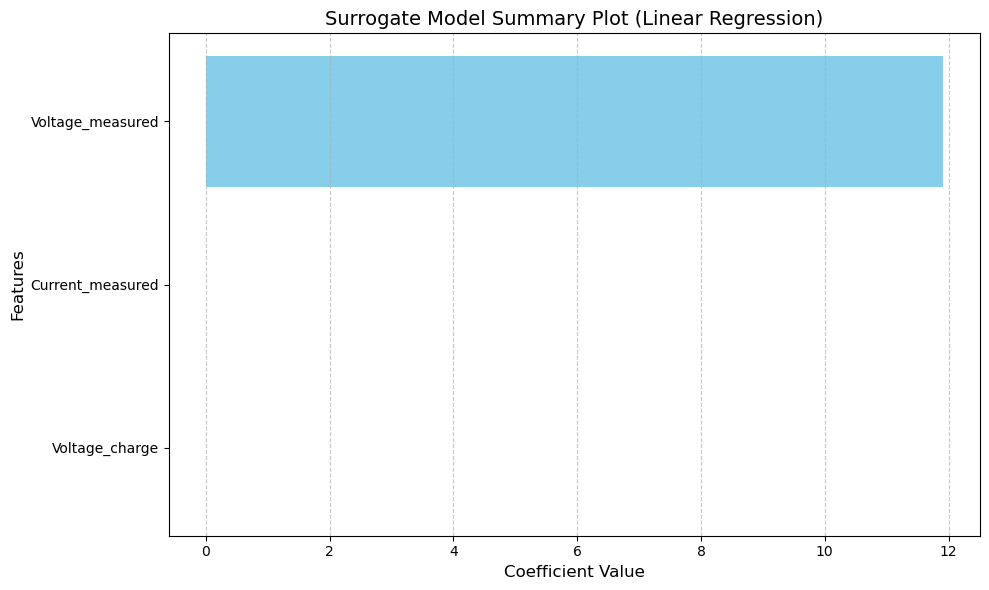

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

surrogate_model = LinearRegression()
surrogate_model.fit(X_soc_test, y_soc_pred_dnn)

feature_importances = pd.DataFrame({
    'Feature': X_soc_test.columns,
    'Coefficient': surrogate_model.coef_.flatten()
})

# Sort features by absolute value of coefficients
feature_importances['Abs_Coefficient'] = np.abs(feature_importances['Coefficient'])
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Surrogate Model Summary Plot (Linear Regression)', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### XAI - DECISION TREE

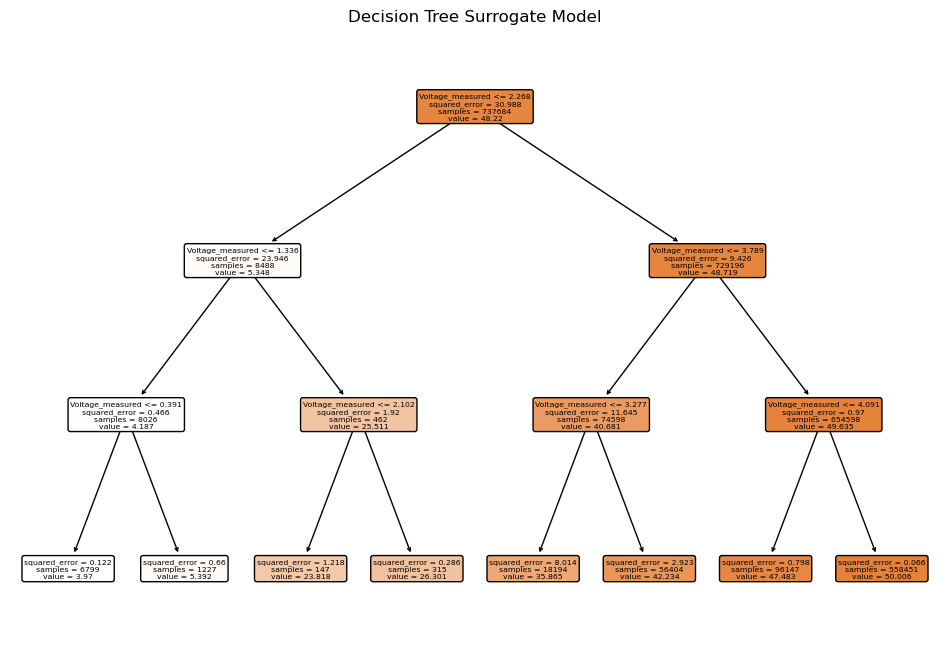

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

#y_soc_pred_dnn = model_soc_dnn.predict(X_soc_test)

# Train a decision tree surrogate
tree_surrogate = DecisionTreeRegressor(max_depth=3, random_state=42)  # Limit depth for interpretability
tree_surrogate.fit(X_soc_test, y_soc_pred_dnn)

# Visualize the tree
plt.figure(figsize=(12, 8))
plot_tree(tree_surrogate, feature_names=X_soc_test.columns, filled=True, rounded=True)
plt.title('Decision Tree Surrogate Model')
plt.show()


In [26]:
from tensorflow.keras.models import load_model

model_soc_dnn = load_model('model_soc_dnn.keras')
print("Model loaded successfully!")

Model loaded successfully!


In [29]:
from sklearn.metrics import mean_squared_error, r2_score

y_surrogate_pred = tree_surrogate.predict(X_soc_test)

mse = mean_squared_error(y_soc_pred_dnn, y_surrogate_pred)

r2 = r2_score(y_soc_pred_dnn, y_surrogate_pred)

print(f"Mean Squared Error (MSE) of the DNN Surrogate Model: {mse:.4f}")
print(f"R² Score of the DNN Surrogate Model: {r2:.4f}")

Mean Squared Error (MSE) of the DNN Surrogate Model: 0.5773
R² Score of the DNN Surrogate Model: 0.9814


#### LSTM for SoC

In [13]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [40]:
X_soc_lstm_train = X_soc_train.values.reshape((X_soc_train.shape[0], 1, X_soc_train.shape[1]))
X_soc_lstm_val = X_soc_val.values.reshape((X_soc_val.shape[0], 1, X_soc_val.shape[1]))
X_soc_lstm_test = X_soc_test.values.reshape((X_soc_test.shape[0], 1, X_soc_test.shape[1]))

model_soc_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(1, X_soc_train.shape[1])),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

model_soc_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history_soc_lstm = model_soc_lstm.fit(X_soc_lstm_train, y_soc_train, epochs=5, batch_size=32, validation_data=(X_soc_lstm_val, y_soc_val))

y_soc_pred_lstm = model_soc_lstm.predict(X_soc_lstm_test)

D:\Apps\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 666s 4ms/step - loss: 11.0641 - mae: 0.3259 - val_loss: 0.0021 - val_mae: 0.0451
Epoch 2/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 651s 4ms/step - loss: 9.3941e-04 - mae: 0.0195 - val_loss: 2.8720e-05 - val_mae: 0.0031
Epoch 3/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 655s 4ms/step - loss: 6.1938e-04 - mae: 0.0156 - val_loss: 3.4987e-05 - val_mae: 0.0030
Epoch 4/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 854s 5ms/step - loss: 4.6966e-04 - mae: 0.0133 - val_loss: 1.4864e-04 - val_mae: 0.0119
Epoch 5/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 637s 4ms/step - loss: 3.9494e-04 - mae: 0.0122 - val_loss: 3.4186e-04 - val_mae: 0.0179
23053/23053 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step


In [41]:
#Evaluate
mse_soc_lstm = mean_squared_error(y_soc_test, y_soc_pred_lstm)
mae_soc_lstm = mean_absolute_error(y_soc_test, y_soc_pred_lstm)
r2_soc_lstm = r2_score(y_soc_test, y_soc_pred_lstm)

print("LSTM Model for SoC:")
print("MSE:", mse_soc_lstm)
print("MAE:", mae_soc_lstm)
print("R2:", r2_soc_lstm)

LSTM Model for SoC:
MSE: 0.0003414458646209141
MAE: 0.017906254938363755
R2: 0.9999889820439668


In [42]:
model_soc_lstm.save('model_soc_lstm.keras')
print("Model saved as 'model_soc_lstm.keras'")

Model saved as 'model_soc_lstm.keras'


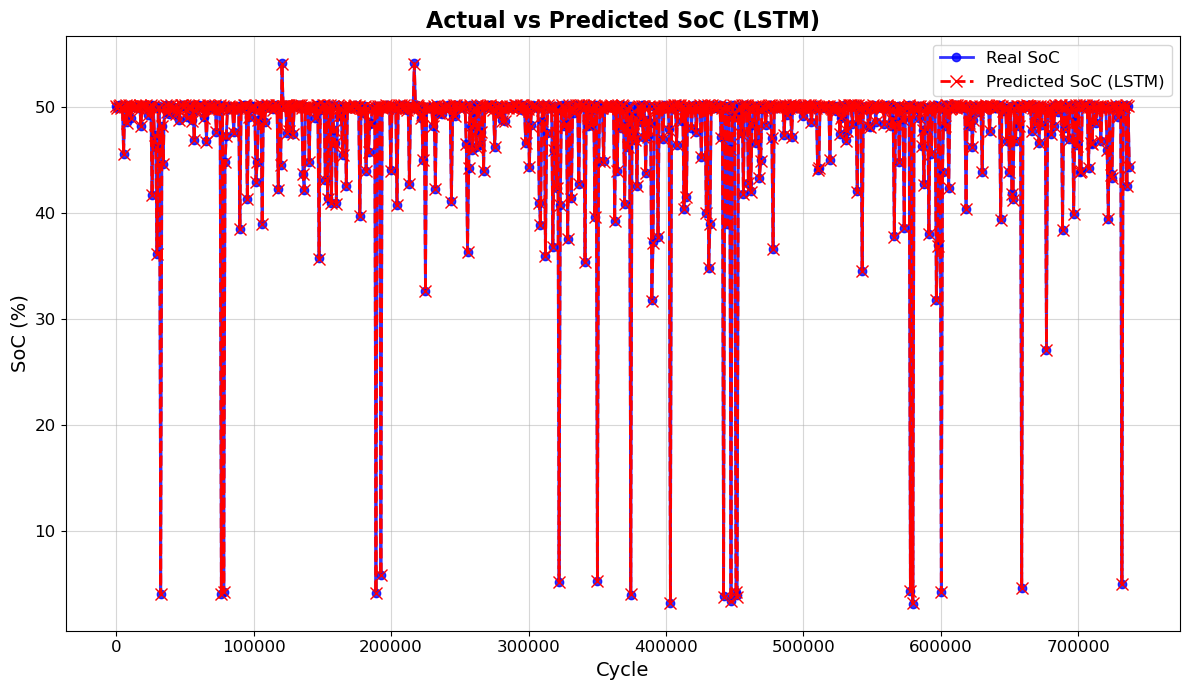

In [43]:
sampling_rate = 900
x_points = np.arange(len(y_soc_test))[::sampling_rate]
y_real_sampled = y_soc_test[::sampling_rate]
y_pred_sampled_lstm = y_soc_pred_lstm[::sampling_rate]  # Use LSTM predictions here

plt.figure(figsize=(12, 7)) 

# Plot Real SoC
plt.plot(
    x_points,
    y_real_sampled,
    label='Real SoC',
    marker='o',
    markersize=6,
    linestyle='-',
    linewidth=2,
    color='blue',
    alpha=0.8, 
)

plt.plot(
    x_points,
    y_pred_sampled_lstm,
    label='Predicted SoC (LSTM)',
    marker='x',
    markersize=8,
    linestyle='--',
    linewidth=2,
    color='red',
    alpha=1,
)

plt.xlabel('Cycle', fontsize=14)
plt.ylabel('SoC (%)', fontsize=14)
plt.title('Actual vs Predicted SoC (LSTM)', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.5)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

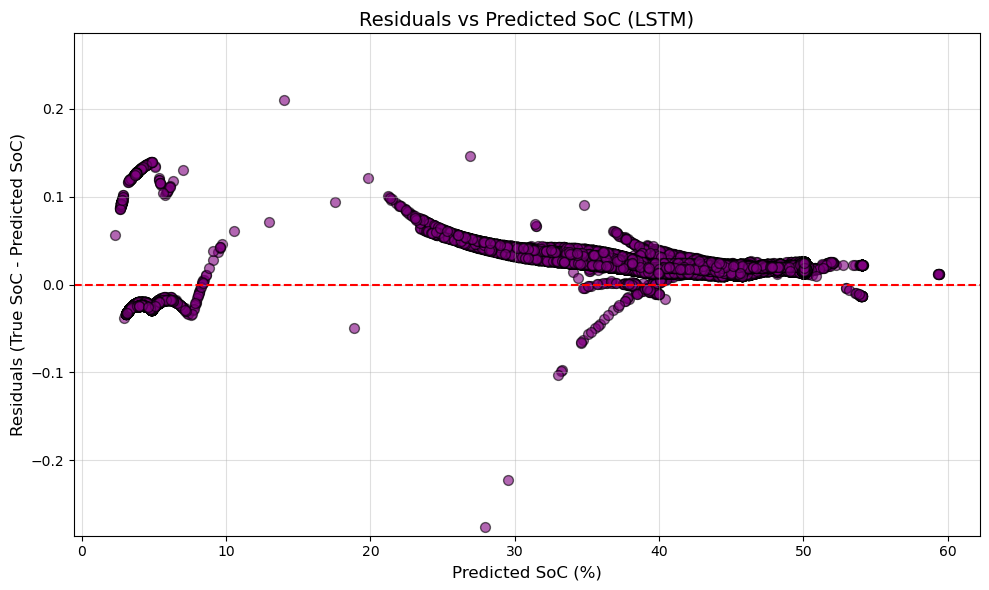

In [44]:
# Calculate residuals
residuals = y_soc_test - y_soc_pred_lstm.flatten()  # Ensure y_soc_pred_lstm is a 1D array

# Determine symmetric limits for the y-axis
max_residual = max(abs(residuals))  # Get the maximum absolute residual
y_limit = max_residual + 0.01  # Add a small buffer for visualization

plt.figure(figsize=(10, 6))

# Scatter plot for residuals vs predicted SoC
plt.scatter(y_soc_pred_lstm, residuals, alpha=0.6, color='purple', edgecolor='black', s=50)

# Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Set the y-axis limits
plt.ylim(-y_limit, y_limit)

# Labels and title
plt.xlabel('Predicted SoC (%)', fontsize=12)
plt.ylabel('Residuals (True SoC - Predicted SoC)', fontsize=12)
plt.title('Residuals vs Predicted SoC (LSTM)', fontsize=14)

# Grid and ticks
plt.grid(alpha=0.4)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## COMPARING DNN AND LSTM

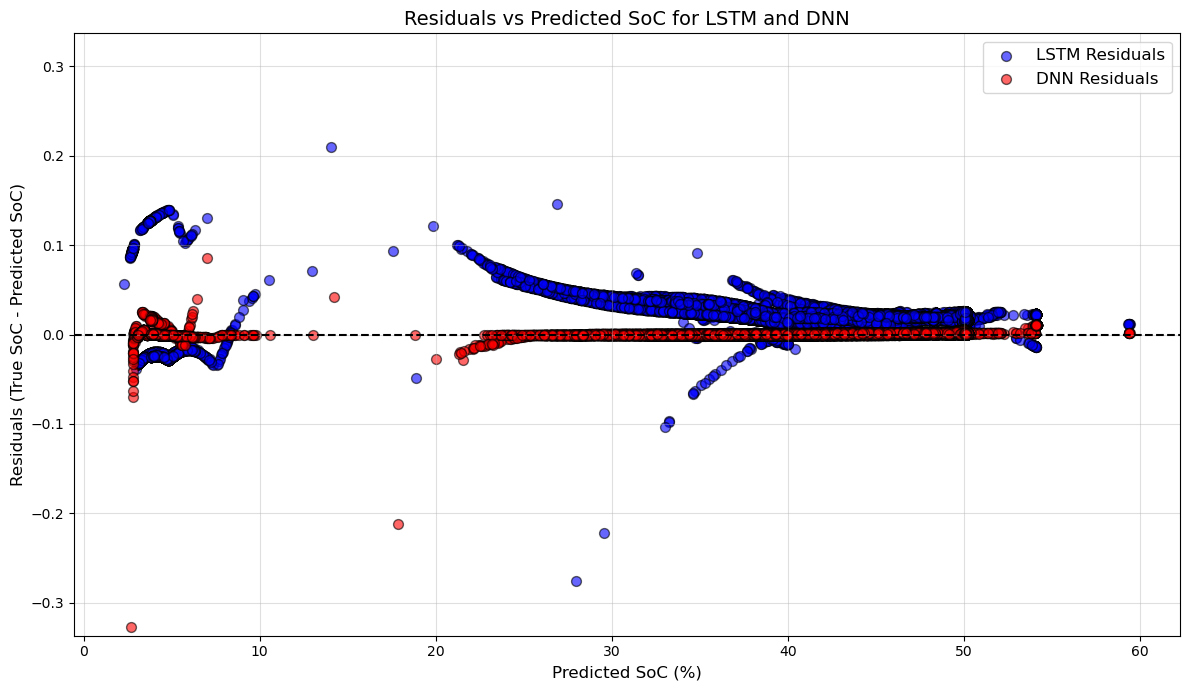

In [45]:
# Calculate residuals for both models
residuals_lstm = y_soc_test - y_soc_pred_lstm.flatten()  # Ensure 1D array for LSTM predictions
residuals_dnn = y_soc_test - y_soc_pred_dnn.flatten()  # Ensure 1D array for DNN predictions

# Determine symmetric limits for the y-axis
max_residual_lstm = max(abs(residuals_lstm))  # Maximum absolute residual for LSTM
max_residual_dnn = max(abs(residuals_dnn))  # Maximum absolute residual for DNN
y_limit = max(max_residual_lstm, max_residual_dnn) + 0.01  # Set a small buffer for better visualization

plt.figure(figsize=(12, 7))

# Plot residuals vs predicted SoC for LSTM
plt.scatter(y_soc_pred_lstm, residuals_lstm, alpha=0.6, color='blue', edgecolor='black', s=50, label='LSTM Residuals')

# Plot residuals vs predicted SoC for DNN
plt.scatter(y_soc_pred_dnn, residuals_dnn, alpha=0.6, color='red', edgecolor='black', s=50, label='DNN Residuals')

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

# Set y-axis limits
plt.ylim(-y_limit, y_limit)

# Labels and title
plt.xlabel('Predicted SoC (%)', fontsize=12)
plt.ylabel('Residuals (True SoC - Predicted SoC)', fontsize=12)
plt.title('Residuals vs Predicted SoC for LSTM and DNN', fontsize=14)

# Add grid and legend
plt.grid(alpha=0.4)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

- DNN's residuals are more centered around 0 and is hence the more superior model
- MAE value of DNN (0.0011) is lower than that of LSTM (0.0179), indicating its superior performance again.
- r2 value almost same (no insights)

### XAI for LSTM (Linear Regression)

In [14]:
from tensorflow.keras.models import load_model

model_soc_lstm = load_model('model_soc_lstm.keras')
print("Model loaded successfully!")

Model loaded successfully!


23053/23053 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step


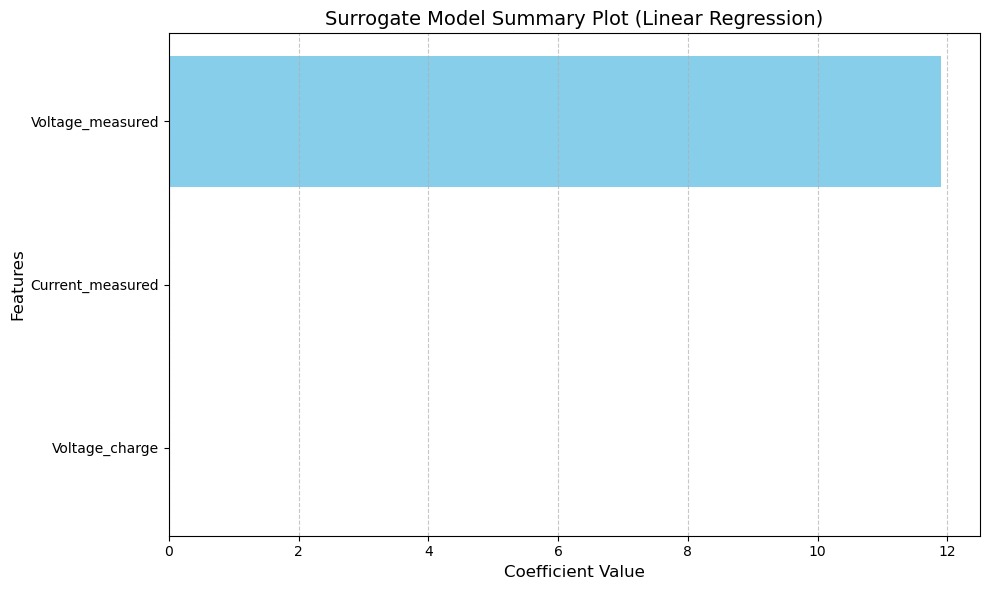

In [21]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# LSTM Test Input is 3D, reshape it to 2D for Linear Regression
X_soc_lstm_test_2d = X_soc_lstm_test.reshape((X_soc_lstm_test.shape[0], X_soc_lstm_test.shape[2]))

# Generate LSTM predictions for the test set
y_soc_pred_lstm = model_soc_lstm.predict(X_soc_lstm_test)

# Train a surrogate Linear Regression model using 2D input
surrogate_model = LinearRegression()
surrogate_model.fit(X_soc_lstm_test_2d, y_soc_pred_lstm)

# Create a DataFrame to store feature importances
feature_importances = pd.DataFrame({
    'Feature': X_soc_test.columns, 
    'Coefficient': surrogate_model.coef_.flatten()
})

# Add absolute values of coefficients for sorting
feature_importances['Abs_Coefficient'] = np.abs(feature_importances['Coefficient'])
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=True)

# Plot the surrogate model summary plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Surrogate Model Summary Plot (Linear Regression)', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### XAI - decision tree

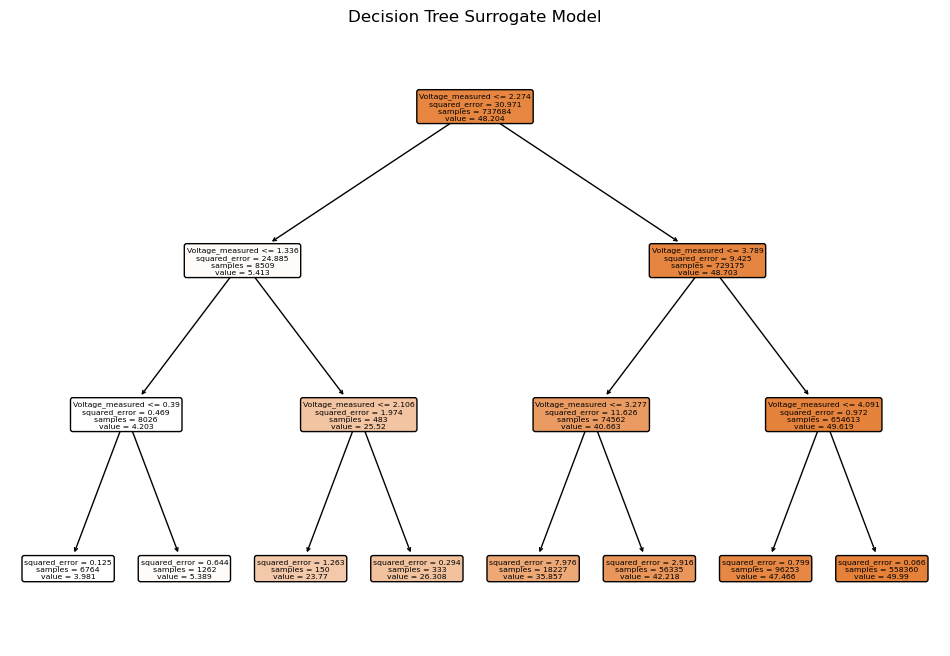

In [23]:
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
import matplotlib.pyplot as plt
import numpy as np

surrogate_model = DecisionTreeRegressor(max_depth=3, random_state=42)
surrogate_model.fit(X_soc_lstm_test_2d, y_soc_pred_lstm)

plt.figure(figsize=(12, 8))
plot_tree(surrogate_model, feature_names=X_soc_test.columns, filled=True, rounded=True)
plt.title('Decision Tree Surrogate Model')
plt.show()

In [25]:
y_surrogate_pred = surrogate_model.predict(X_soc_lstm_test_2d)

mse = mean_squared_error(y_soc_pred_lstm, y_surrogate_pred)
r2 = r2_score(y_soc_pred_lstm, y_surrogate_pred)

print(f"Mean Squared Error (MSE) of the Surrogate Model: {mse:.4f}")
print(f"R² Score of the Surrogate Model: {r2:.4f}")

Mean Squared Error (MSE) of the Surrogate Model: 0.5764
R² Score of the Surrogate Model: 0.9814


- MSE of 0.5764 suggests there is some discrepancy between the surrogate model and the LSTM model, but the error is not extremely large
- R2 score of 0.9814 means that the surrogate model captures 98.14% of the variance in the LSTM predictions. => surrogate model is very good at approximating the behavior of the LSTM model.

## XAI interpretation for SoC

DNN and LSTM models were trained on 3 features:
1. Voltage measured (corr=1)
2. current measured (corr=0.33)
3. voltage charge (corr=0.26)
- Since correlation value of 1 is much greater than the correlation values of the other 2, Voltage_measured alone influences the prediction of the SoC value

XAI results for DNN vs LSTM:
1. DNN (MSE = 0.5773, R2 = 0.9814)
2. LSTM(MSE = 0.5764, R2 = 0.9814)
- both models perform almost identically

# SoH

### DNN for SoH

In [11]:
model_soh_dnn = Sequential([
    Dense(64, activation='relu', input_dim=X_soh_train.shape[1]),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])
model_soh_dnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history_soh_dnn = model_soh_dnn.fit(X_soh_train, y_soh_train, epochs=5, batch_size=32, validation_data=(X_soh_val, y_soh_val))

D:\Apps\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 367s 2ms/step - loss: 2.0645 - mae: 0.1520 - val_loss: 8.6628e-04 - val_mae: 0.0233
Epoch 2/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 409s 3ms/step - loss: 0.0021 - mae: 0.0098 - val_loss: 2.3235e-05 - val_mae: 0.0037
Epoch 3/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 490s 3ms/step - loss: 0.0018 - mae: 0.0095 - val_loss: 6.8944e-07 - val_mae: 6.1796e-04
Epoch 4/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 484s 3ms/step - loss: 0.0014 - mae: 0.0080 - val_loss: 6.9260e-07 - val_mae: 6.9036e-04
Epoch 5/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 477s 3ms/step - loss: 0.0013 - mae: 0.0085 - val_loss: 1.0281e-06 - val_mae: 7.0210e-04


In [12]:
#Evaluate
y_soh_pred_dnn = model_soh_dnn.predict(X_soh_test)
mse_soh = mean_squared_error(y_soh_test, y_soh_pred_dnn)
mae_soh = mean_absolute_error(y_soh_test, y_soh_pred_dnn)
r2_soh = r2_score(y_soh_test, y_soh_pred_dnn)

print("DNN Model for SoH:\nMSE:", mse_soh, "\nMAE:", mae_soh, "\nR^2:", r2_soh)

23053/23053 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
DNN Model for SoH:
MSE: 1.0268793225034482e-06 
MAE: 0.0007022260249060772 
R^2: 0.9999999966668478


In [13]:
model_soh_dnn.save("model_soh_dnn.keras")
print("Model saved as 'model_soh_dnn.keras")

Model saved as 'model_soh_dnn.keras


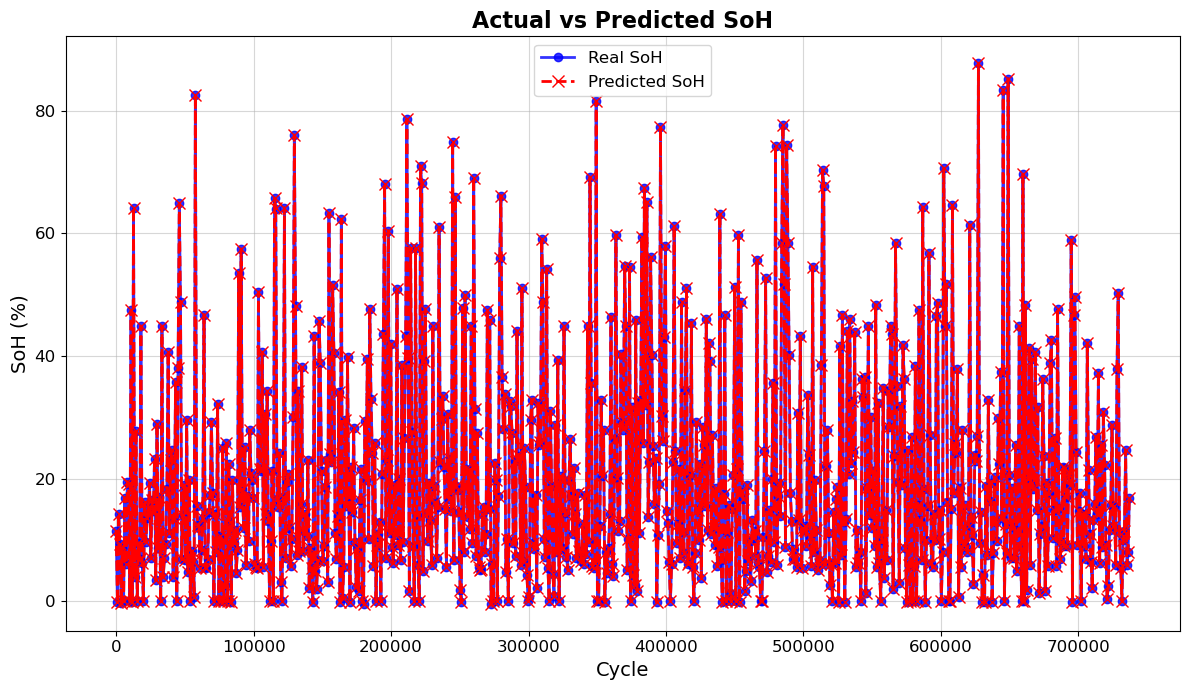

In [14]:
if len(y_soh_pred_dnn.shape) > 1:
    y_soh_pred_dnn = y_soh_pred_dnn.flatten()

sampling_rate = 900
x_points = np.arange(len(y_soh_test))[::sampling_rate]
y_real_sampled = y_soh_test[::sampling_rate]
y_pred_sampled = y_soh_pred_dnn[::sampling_rate]

plt.figure(figsize=(12, 7)) 

# Plot Real Soh
plt.plot(
    x_points,
    y_real_sampled,
    label='Real SoH',
    marker='o',
    markersize=6,
    linestyle='-',
    linewidth=2,
    color='blue',
    alpha=0.8, 
)

# Plot Predicted Soh
plt.plot(
    x_points,
    y_pred_sampled,
    label='Predicted SoH',
    marker='x',
    markersize=8,
    linestyle='--',
    linewidth=2,
    color='red',
    alpha=1,
)

plt.xlabel('Cycle', fontsize=14)
plt.ylabel('SoH (%)', fontsize=14)
plt.title('Actual vs Predicted SoH', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.5)  # Add a light grid for clarity

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

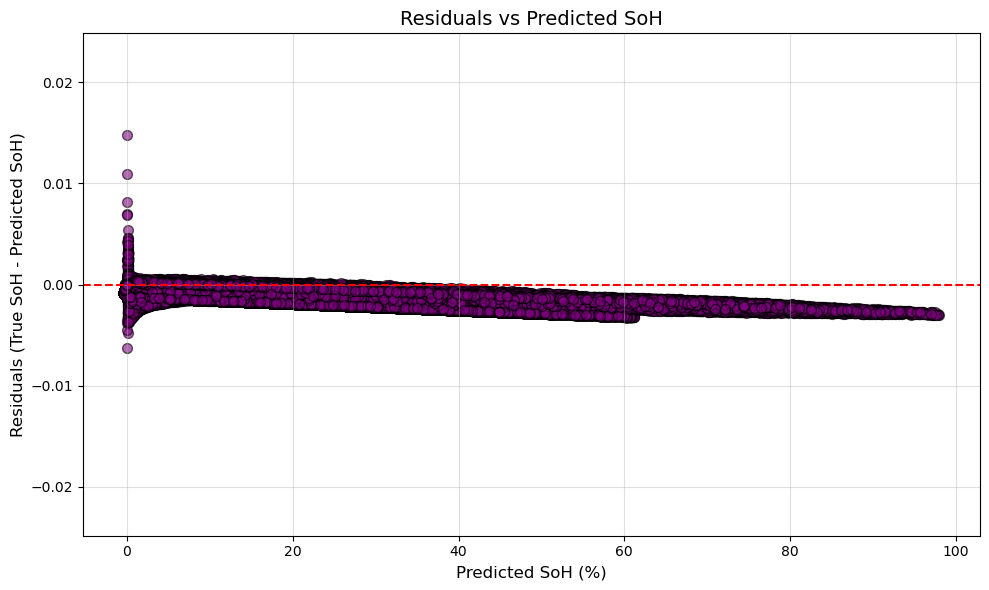

In [15]:
residuals = y_soh_test - y_soh_pred_dnn.flatten()

# Determine symmetric limits for the y-axis
max_residual = max(abs(residuals))  # Get the maximum absolute residual
y_limit = max_residual + 0.01  # Add a small buffer for visualization

plt.figure(figsize=(10, 6))

plt.scatter(y_soh_pred_dnn, residuals, alpha=0.6, color='purple', edgecolor='black', s=50)

# Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

plt.ylim(-y_limit, y_limit)

plt.xlabel('Predicted SoH (%)', fontsize=12)
plt.ylabel('Residuals (True SoH - Predicted SoH)', fontsize=12)
plt.title('Residuals vs Predicted SoH', fontsize=14)

plt.grid(alpha=0.4)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

### XAI - Surrogate Model (Linear Regression) for SoH

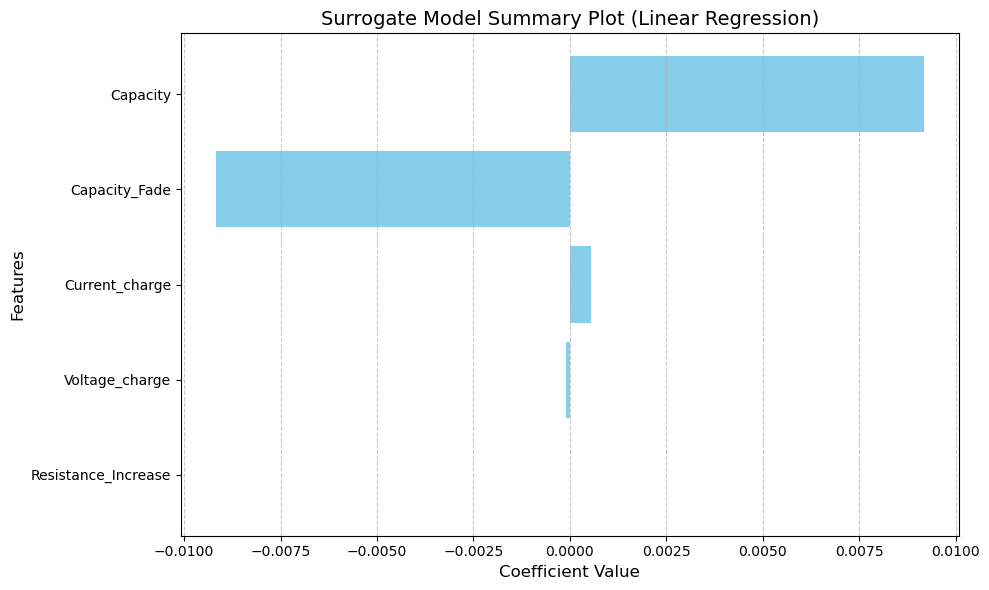

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

surrogate_model = LinearRegression()
surrogate_model.fit(X_soh_test, y_soh_pred_dnn)

feature_importances = pd.DataFrame({
    'Feature': X_soh_test.columns,
    'Coefficient': surrogate_model.coef_.flatten()
})

# Sort features by absolute value of coefficients
feature_importances['Abs_Coefficient'] = np.abs(feature_importances['Coefficient'])
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Surrogate Model Summary Plot (Linear Regression)', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### XAI - Surrogate Model (decision tree) for SoH

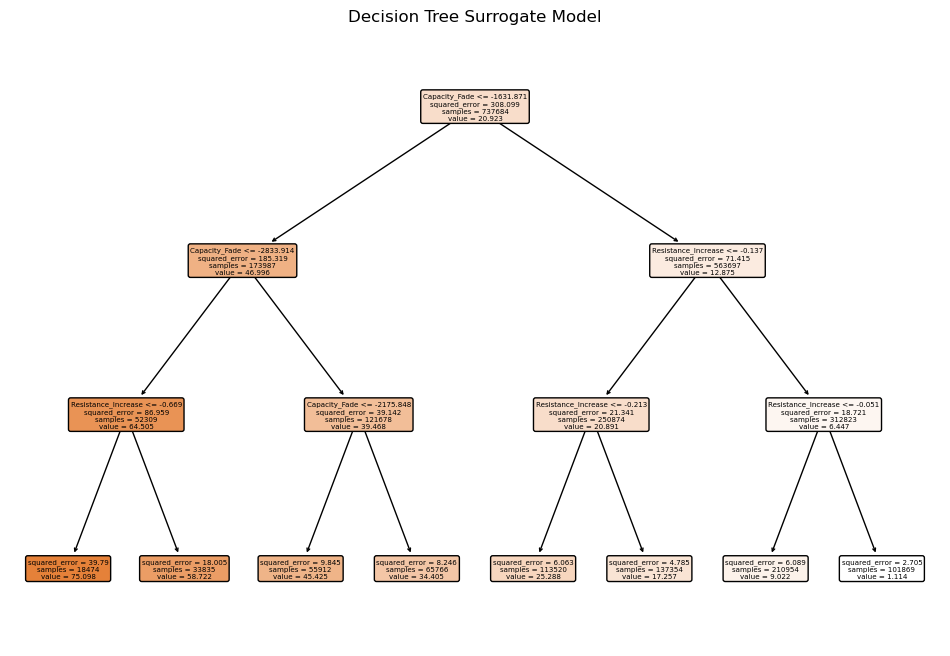

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

# Train a decision tree surrogate
tree_surrogate = DecisionTreeRegressor(max_depth=3, random_state=42)  # Limit depth for interpretability
tree_surrogate.fit(X_soh_test, y_soh_pred_dnn)

# Visualize the tree
plt.figure(figsize=(12, 8))
plot_tree(tree_surrogate, feature_names=X_soh_test.columns, filled=True, rounded=True)
plt.title('Decision Tree Surrogate Model')
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

y_surrogate_pred = tree_surrogate.predict(X_soh_test)

mse = mean_squared_error(y_soh_pred_dnn, y_surrogate_pred)

r2 = r2_score(y_soh_pred_dnn, y_surrogate_pred)

print(f"Mean Squared Error (MSE) of the DNN Surrogate Model: {mse:.4f}")
print(f"R² Score of the DNN Surrogate Model: {r2:.4f}")

Mean Squared Error (MSE) of the DNN Surrogate Model: 7.2425
R² Score of the DNN Surrogate Model: 0.9765


### LSTM for SoH

In [21]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [22]:
X_soh_lstm_train = X_soh_train.values.reshape((X_soh_train.shape[0], 1, X_soh_train.shape[1]))
X_soh_lstm_val = X_soh_val.values.reshape((X_soh_val.shape[0], 1, X_soh_val.shape[1]))
X_soh_lstm_test = X_soh_test.values.reshape((X_soh_test.shape[0], 1, X_soh_test.shape[1]))

model_soh_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(1, X_soh_train.shape[1])),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

model_soh_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history_soh_lstm = model_soh_lstm.fit(X_soh_lstm_train, y_soh_train, epochs=5, batch_size=32, validation_data=(X_soh_lstm_val, y_soh_val))

D:\Apps\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 648s 4ms/step - loss: 3.2422 - mae: 0.0686 - val_loss: 0.0330 - val_mae: 0.1391
Epoch 2/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 621s 4ms/step - loss: 0.0034 - mae: 0.0111 - val_loss: 2.4536e-05 - val_mae: 0.0039
Epoch 3/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 633s 4ms/step - loss: 0.0110 - mae: 0.0103 - val_loss: 6.5155e-07 - val_mae: 4.6097e-04
Epoch 4/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 629s 4ms/step - loss: 0.0038 - mae: 0.0066 - val_loss: 3.0908e-05 - val_mae: 0.0043
Epoch 5/5
161369/161369 ━━━━━━━━━━━━━━━━━━━━ 624s 4ms/step - loss: 0.0035 - mae: 0.0065 - val_loss: 1.2959e-06 - val_mae: 7.7776e-04


In [23]:
y_soh_pred_lstm = model_soh_lstm.predict(X_soh_lstm_test)

#Evaluate
mse_soh_lstm = mean_squared_error(y_soh_test, y_soh_pred_lstm)
mae_soh_lstm = mean_absolute_error(y_soh_test, y_soh_pred_lstm)
r2_soh_lstm = r2_score(y_soh_test, y_soh_pred_lstm)

print("LSTM Model for SoH:")
print("MSE:", mse_soh_lstm)
print("MAE:", mae_soh_lstm)
print("R2:", r2_soh_lstm)

23053/23053 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step
LSTM Model for SoH:
MSE: 1.2935871420853116e-06
MAE: 0.000776767362241529
R2: 0.9999999958011397


In [24]:
model_soh_lstm.save('model_soh_lstm.keras')
print("Model saved as 'model_soh_lstm.keras'")

Model saved as 'model_soh_lstm.keras'


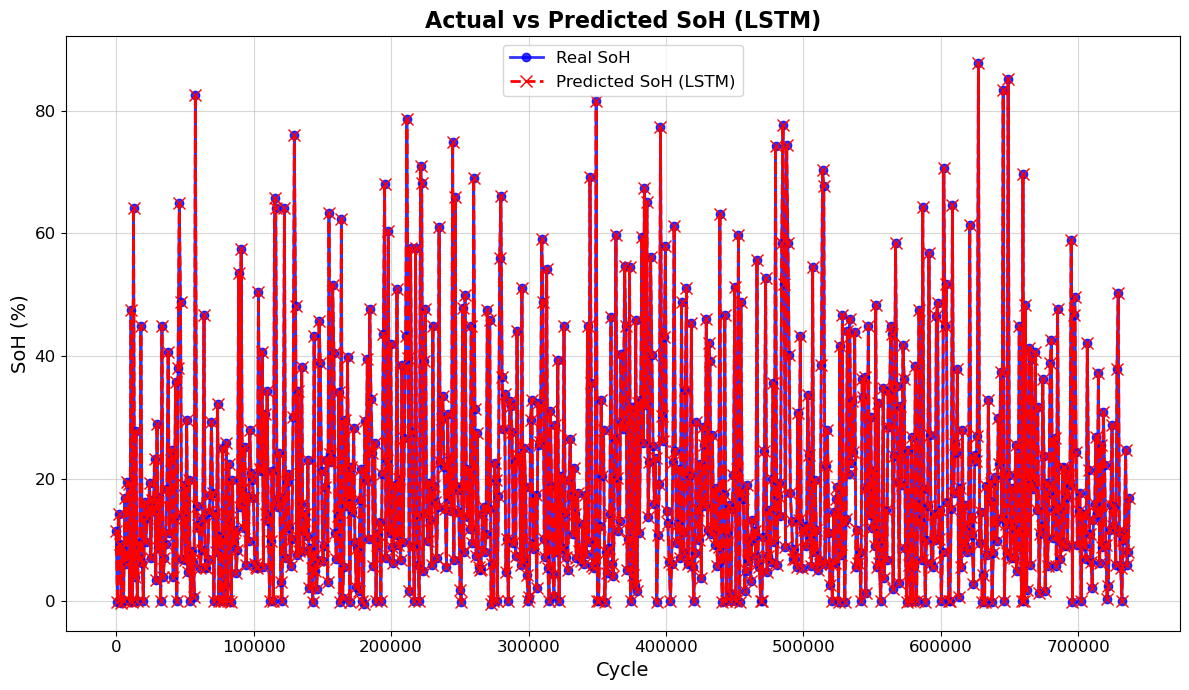

In [25]:
sampling_rate = 900
x_points = np.arange(len(y_soh_test))[::sampling_rate]
y_real_sampled = y_soh_test[::sampling_rate]
y_pred_sampled_lstm = y_soh_pred_lstm[::sampling_rate]  # Use LSTM predictions here

plt.figure(figsize=(12, 7)) 

plt.plot(
    x_points,
    y_real_sampled,
    label='Real SoH',
    marker='o',
    markersize=6,
    linestyle='-',
    linewidth=2,
    color='blue',
    alpha=0.8, 
)

plt.plot(
    x_points,
    y_pred_sampled_lstm,
    label='Predicted SoH (LSTM)',
    marker='x',
    markersize=8,
    linestyle='--',
    linewidth=2,
    color='red',
    alpha=1,
)

plt.xlabel('Cycle', fontsize=14)
plt.ylabel('SoH (%)', fontsize=14)
plt.title('Actual vs Predicted SoH (LSTM)', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.5)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

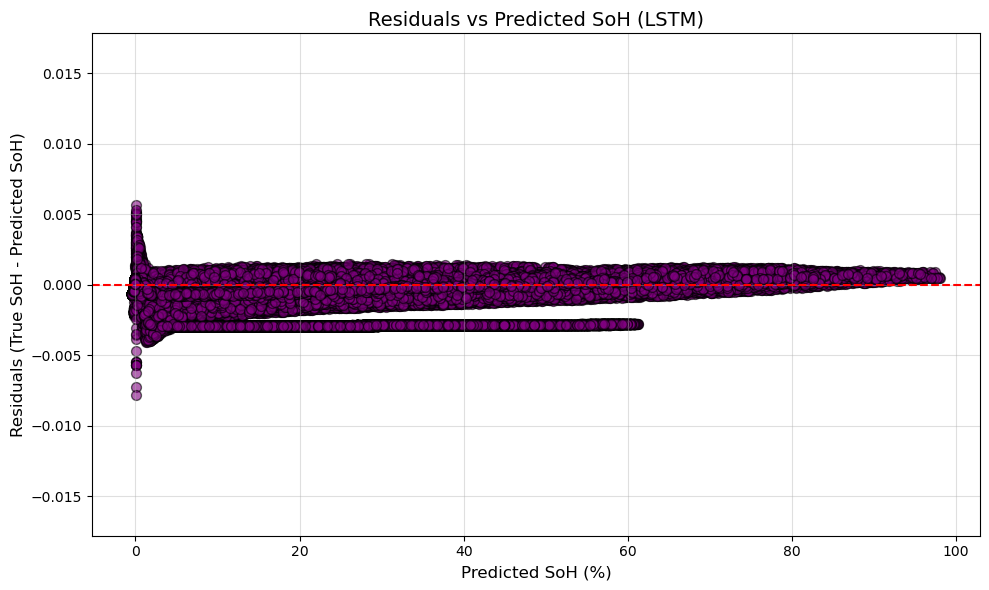

In [26]:
# Calculate residuals
residuals = y_soh_test - y_soh_pred_lstm.flatten()  # Ensure y_soh_pred_lstm is a 1D array

# Determine symmetric limits for the y-axis
max_residual = max(abs(residuals))  # Get the maximum absolute residual
y_limit = max_residual + 0.01  # Add a small buffer for visualization

plt.figure(figsize=(10, 6))

# Scatter plot for residuals vs predicted Soh
plt.scatter(y_soh_pred_lstm, residuals, alpha=0.6, color='purple', edgecolor='black', s=50)

# Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Set the y-axis limits
plt.ylim(-y_limit, y_limit)

# Labels and title
plt.xlabel('Predicted SoH (%)', fontsize=12)
plt.ylabel('Residuals (True SoH - Predicted SoH)', fontsize=12)
plt.title('Residuals vs Predicted SoH (LSTM)', fontsize=14)

# Grid and ticks
plt.grid(alpha=0.4)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## XAI for LSTM (Linear Regression)

23053/23053 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step


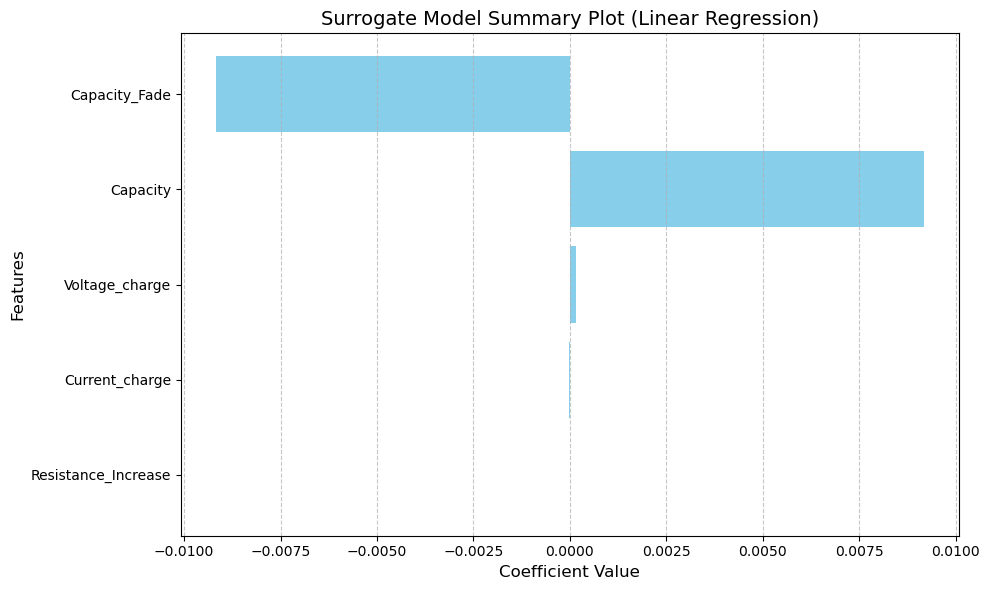

In [32]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

X_soh_lstm_test_2d = X_soh_lstm_test.reshape((X_soh_lstm_test.shape[0], X_soh_lstm_test.shape[2]))

# Generate LSTM predictions for the test set
y_soh_pred_lstm = model_soh_lstm.predict(X_soh_lstm_test)

# Train a surrogate Linear Regression model using 2D input
surrogate_model = LinearRegression()
surrogate_model.fit(X_soh_lstm_test_2d, y_soh_pred_lstm)

# Create a DataFrame to store feature importances
feature_importances = pd.DataFrame({
    'Feature': X_soh_test.columns, 
    'Coefficient': surrogate_model.coef_.flatten()
})

# Add absolute values of coefficients for sorting
feature_importances['Abs_Coefficient'] = np.abs(feature_importances['Coefficient'])
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=True)

# Plot the surrogate model summary plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Surrogate Model Summary Plot (Linear Regression)', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### XAI - decision Tree

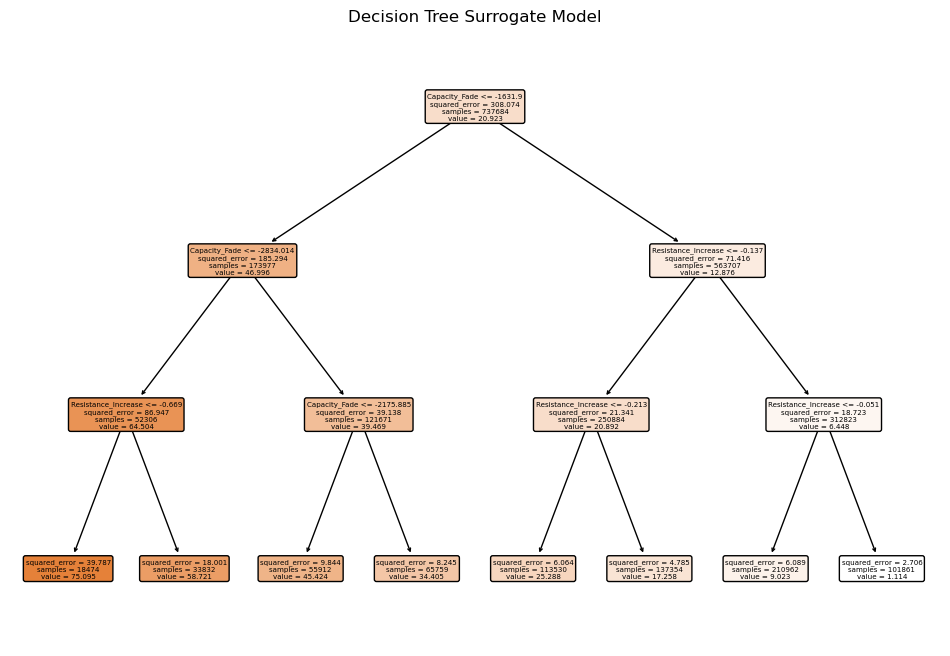

In [34]:
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
import matplotlib.pyplot as plt
import numpy as np

surrogate_model = DecisionTreeRegressor(max_depth=3, random_state=42)
surrogate_model.fit(X_soh_lstm_test_2d, y_soh_pred_lstm)

plt.figure(figsize=(12, 8))
plot_tree(surrogate_model, feature_names=X_soh_test.columns, filled=True, rounded=True)
plt.title('Decision Tree Surrogate Model')
plt.show()

In [35]:
y_surrogate_pred = surrogate_model.predict(X_soh_lstm_test_2d)

mse = mean_squared_error(y_soh_pred_lstm, y_surrogate_pred)
r2 = r2_score(y_soh_pred_lstm, y_surrogate_pred)

print(f"Mean Squared Error (MSE) of the Surrogate Model: {mse:.4f}")
print(f"R² Score of the Surrogate Model: {r2:.4f}")

Mean Squared Error (MSE) of the Surrogate Model: 7.2420
R² Score of the Surrogate Model: 0.9765


## Comparing DNN and LSTM for SoH

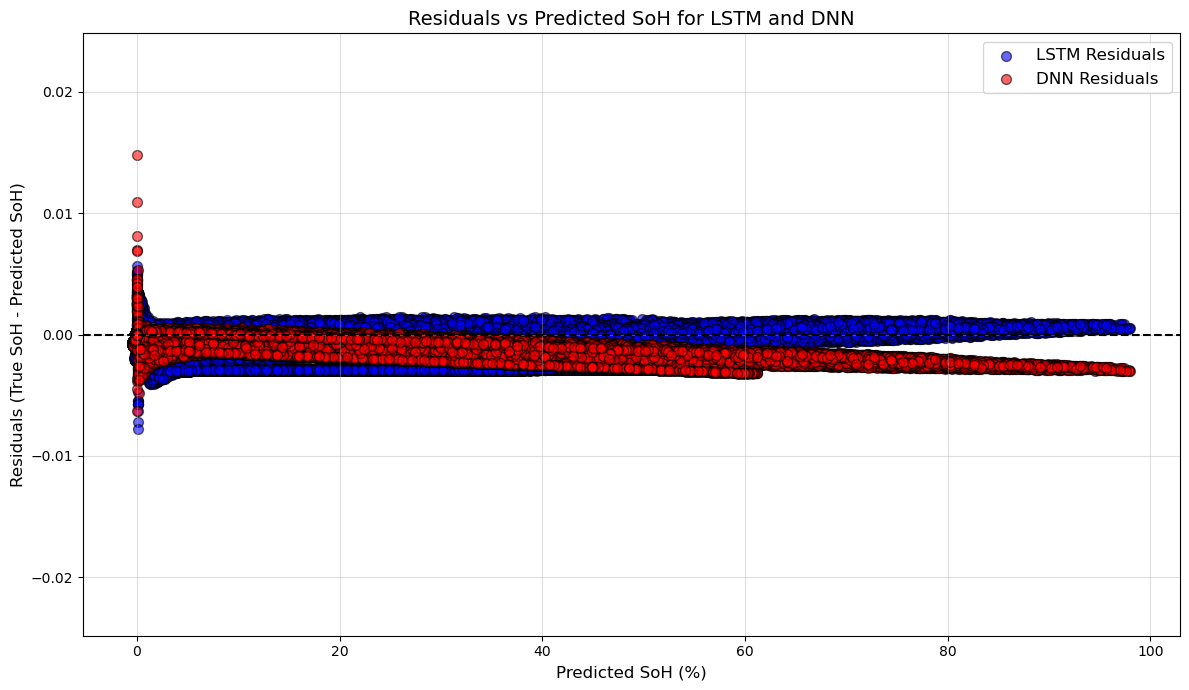

In [28]:
# Calculate residuals for both models
residuals_lstm = y_soh_test - y_soh_pred_lstm.flatten()  # Ensure 1D array for LSTM predictions
residuals_dnn = y_soh_test - y_soh_pred_dnn.flatten()  # Ensure 1D array for DNN predictions

# Determine symmetric limits for the y-axis
max_residual_lstm = max(abs(residuals_lstm))  # Maximum absolute residual for LSTM
max_residual_dnn = max(abs(residuals_dnn))  # Maximum absolute residual for DNN
y_limit = max(max_residual_lstm, max_residual_dnn) + 0.01  # Set a small buffer for better visualization

plt.figure(figsize=(12, 7))

# Plot residuals vs predicted Soh for LSTM
plt.scatter(y_soh_pred_lstm, residuals_lstm, alpha=0.6, color='blue', edgecolor='black', s=50, label='LSTM Residuals')

# Plot residuals vs predicted Soh for DNN
plt.scatter(y_soh_pred_dnn, residuals_dnn, alpha=0.6, color='red', edgecolor='black', s=50, label='DNN Residuals')

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

# Set y-axis limits
plt.ylim(-y_limit, y_limit)

# Labels and title
plt.xlabel('Predicted SoH (%)', fontsize=12)
plt.ylabel('Residuals (True SoH - Predicted SoH)', fontsize=12)
plt.title('Residuals vs Predicted SoH for LSTM and DNN', fontsize=14)

# Add grid and legend
plt.grid(alpha=0.4)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

- DNN Model for SoH:
  1. MSE: 1.0268793225034482e-06 
  2. MAE: 0.0007022260249060772 
  3. R^2: 0.9999999966668478
- LSTM Model for SoH:
  1. MSE: 1.2935871420853116e-06
  2. MAE: 0.000776767362241529
  3. R2: 0.9999999958011397

From the above stats, DNN is again superior 

#### XAI interpretation (DNN vs LSTM)

1. DNN:
   - Mean Squared Error (MSE) of the DNN Surrogate Model: 7.2425
   - R2 Score of the DNN Surrogate Model: 0.9765
2. LSTM:
   - Mean Squared Error (MSE) of the Surrogate Model: 7.2420
   - R2 Score of the Surrogate Model: 0.9765

- The MSE values are extremely close. Both surrogate models approximate their original models (DNN and LSTM) with nearly the same level of error.
- The R² score is the same for both surrogate models, meaning each surrogate model captures 97.65% of the variance in the predictions of their respective original models.